Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 07: EEG simulation & filtering in 2-D

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, June 18, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this sheet we are going dig deeper into signal processing. Specifically, we will learn how the basic concepts in signal processing expand to 2-D space. You will need to have understandings of what fourier transform and inverse transform do and what kind of effect convolution has.

 Let's say your friend wants to send you a deep picture per messaging app. But he is too afraid that the server might get hacked. Therefore he decides to add some noise in his picture and just sends you the 2d shaped text file of the image. Now you have to denoise the image to see it. Surely you can use a simple filtering function to achieve this, but that sounds too boring for you. Instead, you want to convolve the filter and the image in a spatial domain.

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import fftpack
from scipy import signal
import scipy.stats as st
import matplotlib.colors as colors

## Assignment 0: Peer review for sheet 07 [0 pts]

This week there will be no peer-review for obvious reasons.

## Assignment 1: Simulate 4-channel EEG signal [4 pts]

Before starting with the image, we will try to approximate an actual EEG signal as an extension from next week's sheet. Although our later EEG data will be composed of 64 channels, we will stick with 4 for simplicity. 

### a) Generate signal [3 pts]

Write a function that creates the signal for one channel, given a certain frequency-list (4 different frequencies) and the length of the signal. 
Within the function:
- First, define a sampling rate of 1000 Hz and a time-window of 1 second (i.e. 1000 ms)
- Define a list that assigns an amplitude to each element of frequencyList: For this, randomly draw with replacement from a range between 0 and 30 (hint: you need as many amplitude-samples as number of elements in frequencyList, checkout *np.random.choice*)
- Create each signal component with given frequency and amplitude. Add them all up.
- Add a small Gaussian noise to the signal.

In [2]:
def generateSignal(frequencyList,signalLen=1000):
    # sampling rate of 1000Hz
    srate = 1000
    # time-window of 1 second
    t = np.linspace(0, 1, 1000, False)
    # amplitude samples
    amps = np.random.choice(30,len(frequencyList))

    sig = []
    # create each signal component with the given frequency and the randomly sampled amplitude
    for i in range(len(frequencyList)):
        sine = amps[i] * np.sin(2*np.pi* frequencyList[i]* t)
        sig.append(sine)
    
    # generate some random noise
    noise = np.random.normal(0,2.0,1000)
    # add up the different frequencies and some noise
    signal = sum(sig)+ noise
    
    return signal

### b) Plot [1 pt]
Once you wrote the function, use it to create 4 differnet signals (which each represent a channel). To make it more realistic, randomly sample frequencies of each signal from a common EEG frequency-band. These 4 common EEG frequency-bands are already given below.
 
Lastly, plot these 4 different signals.

In [3]:
# define frequency-bands typical for EEG data
delta = list(range(0,4))
theta = list(range(4,8))
alpha = list(range(8,14))
beta = list(range(13,31))
frexlist = [delta, theta, alpha, beta]

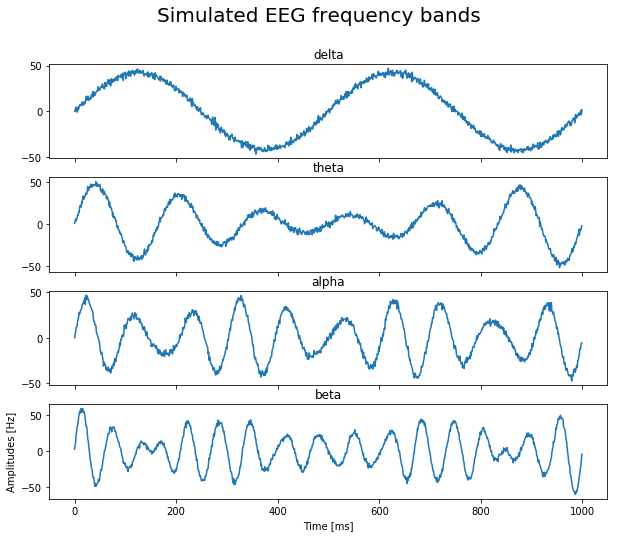

In [4]:
# create 4 signals for each channel, with random frequency combinations
signals = []
# loop over the 4 frequency bands
for frexband in frexlist:
    # from each band sample 4 signals
    channels = np.random.choice(frexband, 4)
    # use the function to generate the signals and append them in the signals list
    signals.append(generateSignal(channels, signalLen=1000)) 

# plot
# create the figure for the subplots     
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10,8))

# set a title 
fig.suptitle('Simulated EEG frequency bands', fontsize=20)

# label the axes
plt.xlabel('Time [ms]')
plt.ylabel('Amplitudes [Hz]')

# finally plot the 4 different plots
axs[0].plot(signals[0])
axs[0].set(title='delta')
axs[1].plot(signals[1])
axs[1].set(title='theta')
axs[2].plot(signals[2])
axs[2].set(title='alpha')
axs[3].plot(signals[3])
axs[3].set(title='beta')

plt.show()

### BONUS!
### a) Power-Spectogram
compute and plot the nice and colorful power-spectogram of our signals with *plt.specgram*

<function matplotlib.pyplot.show(*args, **kw)>

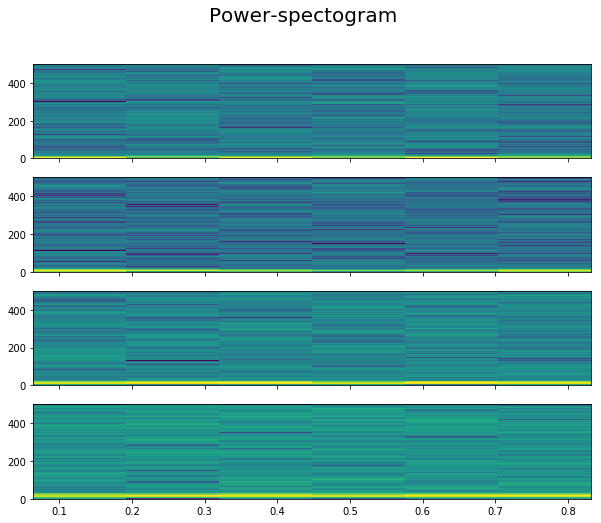

In [25]:
# compute and plot power-spectogram for the signals
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10,8))
for i in range(len(signals)):
    axs[i].specgram(x = signals[i], Fs=1000)
    plt.suptitle('Power-spectogram', fontsize=20)
plt.show

## Assignment 2: Load the data [1 pts]
Now let's start cracking the puzzle. Because your friend just sent you some text file, you need to load them into an image.
- First load the text file into a numpy array.
- Plot this numpy array. Use a gray colormap.

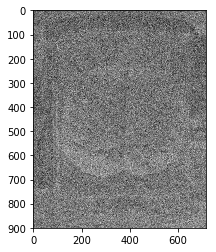

In [6]:
# load the puzzle into an array and plot it
puzzle = np.loadtxt(fname='important.txt')
plt.imshow(puzzle, cmap='gray')

## Asignment 3: Fourier transform [2 pts]
Do a fourier transform on the image.
- Don't panic. It's just the same concept, only in a 2-D space rather than in a 1-D space. 
- If you use ***numpy.fftpack.fft2***, you should shift the zero-frequency component to be at the center by ***numpy.fftpack.fftshift***.
- You should plot the power spectrum of the fourier transformed image at the end. 
- See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/ for differences between magnitiude, phase and power (amplitude).
- Use log scale in the plot. Check the parameter @norm of ***matplotlib.pyplot.imshow***.

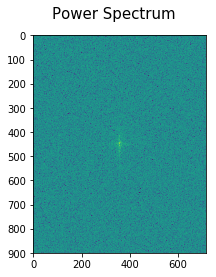

In [7]:
# compute the fourier transform of the image and shift it to be zero centered
#fft = fftpack.fftshift(fftpack.fft2(puzzle))
fft = fftpack.fftshift(fftpack.fft2(puzzle))

# calculate the power spectrum of the shifted fourier transformed image
powerspec = np.abs(fft)**2

# plot the spectrum using log scale, take the min and max values from our powerspec to normalize
plt.imshow(powerspec, norm=colors.LogNorm(vmin=powerspec.min(), vmax=powerspec.max()))

# set a title 
plt.suptitle('Power Spectrum', fontsize=15)

plt.show()

## Assignment 4: Create low pass filter [2 pts]
To filter the image, you need a filter. We are going to use a low pass filter (2-D Gaussian). 
- Your distribution should be rotationally symmetric for every angle.
- The filter should have 120 x 120 size, and the standard deviation should be 3.
- In our case it's easy to go from 1-D Gaussian distribution to 2-D Gaussian distribution, because there are no interaction between two dimensions (covariance matrix would be diagonal).
- Plot your filter.

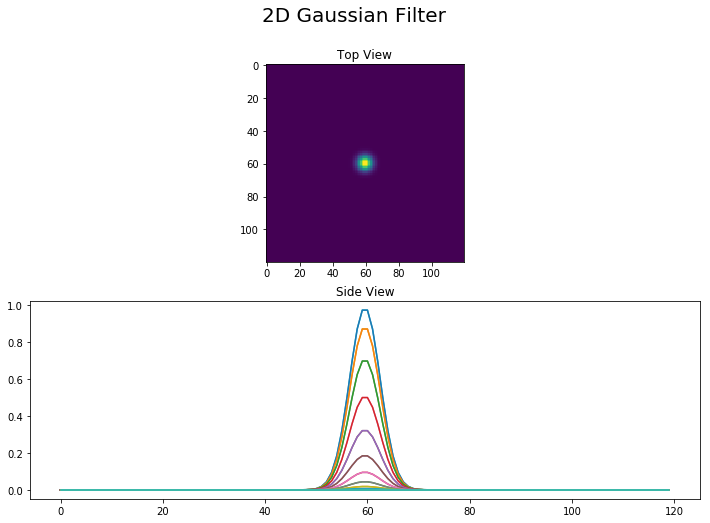

In [15]:
# As we know that the gaussian 2D kernel is separable we can use the outer product of a 1D gaussian kernel to generate it
# first generate the 1D version
filter1D = signal.gaussian(M=120, std=3, sym=True)
# then multiply it with itself for the 2D version
filter2D = np.outer(filter1D, filter1D)

# plot the filter 
# compute the inverse of the two
inverse_img = fftpack.ifft2(fft)
# for the filter it is important to shift it back, because otherwise there will be weird distorsions in the end
inverse_filter = fftpack.ifftshift(fftpack.ifft2(filter2D))

# calculate the power spectrum as before
powerspec_img = np.abs(inverse_img)**2
powerspec_filter = np.abs(inverse_filter)**2

# plot both power spectra
fig, axs = plt.subplots(2, 1, figsize=(12,8))

# set a title 
fig.suptitle('2D Gaussian Filter', fontsize=20)

axs[0].imshow(filter2D)
axs[0].set(title='Top View')

axs[1].plot(filter2D)
axs[1].set(title='Side View')

plt.show()

## Assignment 5: Back to space [2 pts]
Right now the picture and the filters are both in frequency domain. Let's bring them back to the spatial domain. For this, you can use an inverse fourier transform function (I know, we computed fourier transform of the picture for nothing). 
- Compute the inverse fourier transform for both the image and the kernel.
- Compute power spectrum of these.

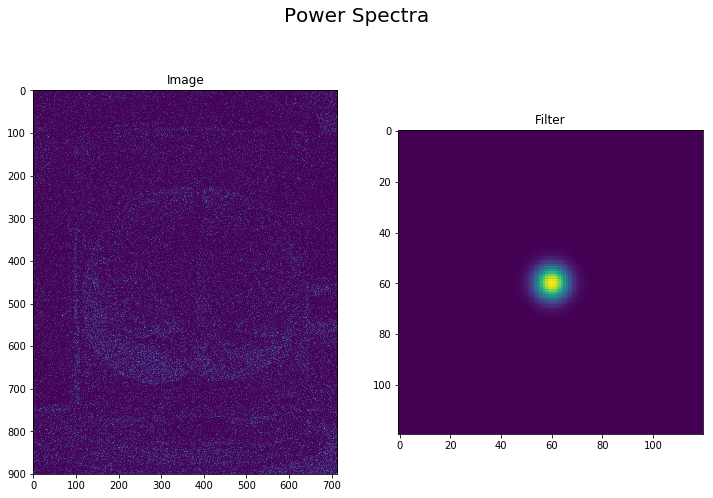

In [12]:
# compute the inverse of the two
inverse_img = fftpack.ifft2(fft)
# for the filter it is important to shift it back, because otherwise there will be weird distorsions in the end
inverse_filter = fftpack.ifftshift(fftpack.ifft2(filter2D))

# calculate the power spectrum as before
powerspec_img = np.abs(inverse_img)**2
powerspec_filter = np.abs(inverse_filter)**2

# plot both power spectra
fig, axs = plt.subplots(1, 2, figsize=(12,8))

# set a title 
fig.suptitle('Power Spectra', fontsize=20)

axs[0].imshow(powerspec_img)
axs[0].set(title='Image')

axs[1].imshow(powerspec_filter)
axs[1].set(title='Filter')

plt.show()

## Assignment 6: Convolution [2 pts]

To boost your intuition of convoultion in 2-d space, I recommend the following blog article.
http://www.songho.ca/dsp/convolution/convolution2d_example.html


We are almost there. Now we just have to convolve the image and the filter in spatial domain (use the computed power spectra of assignment 5 for this) and plot the picture. Do you recognise the object in the picture?

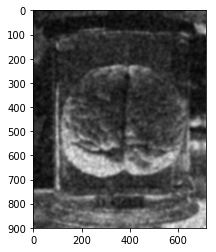

In [13]:
# use the computed power spectrum in order to obtain the filtered image in the spatial domain
filtered_img = ndimage.convolve(powerspec_img, powerspec_filter)

# plot the filtered image
plt.imshow(filtered_img, interpolation='gaussian',cmap='gray')
plt.show()

What do you see? 

A brain in a jar.